# Augmented Potts Model

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from utils import seq_dict_from_fasta, compute_hamiltonians, filter_msa_to_ref_seq, confidence_interval

In [2]:
data_root = Path("../data")

## Compute Hamiltonians for ADK sequences

In [3]:
bs_focus_model_path = data_root / "plmc/adk_175_org_bs_focus.model_params"

seq_dict = seq_dict_from_fasta(data_root / "175_adk_org_aligned.fasta")

filtered_seq_df = filter_msa_to_ref_seq(sequence_dictionary=seq_dict,
                                        ref_seq_name="bacillus_subtilis")

bs_focus_hamiltonian_df = compute_hamiltonians(coupling_model_path=bs_focus_model_path,
                                        model_name="175_adk_bs_focus", 
                                        seq_list=list(filtered_seq_df["seq"]),
                                        org_name_list=list(filtered_seq_df["org_name"]))


In [4]:
bs_focus_big_model_path = data_root / "plmc/big_adk_bs_focus.model_params"
seq_dict = seq_dict_from_fasta(data_root / "all_adk_representative_seqs_bacdive_aligned.fasta")
filtered_seq_df = filter_msa_to_ref_seq(sequence_dictionary=seq_dict,
                                        ref_seq_name="bacillus_subtilis")
big_bs_focus_hamiltonian_df = compute_hamiltonians(coupling_model_path=bs_focus_big_model_path,
                                        model_name="5149_adk_bs_focus", 
                                        seq_list=list(filtered_seq_df["seq"]),
                                        org_name_list=list(filtered_seq_df["org_name"]))

In [5]:
merged_hamiltonian_df = pd.merge(bs_focus_hamiltonian_df, big_bs_focus_hamiltonian_df, on=["org_name"], how="inner")

## Dataset Prep

In [6]:
one_hot_encodings = pd.read_csv(data_root / "one_hot_msa_175_orgs.csv")
dataset = pd.read_csv(data_root / 'adk_ml_dataset.csv')
dataset = dataset[["org_name", "log10_kcat", "log10_km"]]

In [7]:
# merge dataset with one-hot encodings and hamiltonians
combined_dataset = pd.merge(one_hot_encodings, merged_hamiltonian_df, on='org_name')
# add a StandardScaler norm on the hamiltonian
combined_dataset["potts_175_normed"] = StandardScaler().fit_transform(combined_dataset["175_adk_bs_focus"].values.reshape(-1, 1))
combined_dataset["potts_5149_normed"] = StandardScaler().fit_transform(combined_dataset["5149_adk_bs_focus"].values.reshape(-1, 1))
combined_dataset = pd.merge(combined_dataset, dataset, on='org_name')
combined_dataset.set_index('org_name', inplace=True)

In [8]:
split_dict = json.load(open(data_root / "adk_175_org_bootstrap_stratified_split.json"))

In [9]:
N_SAMPLES = 30
num_sizes = 1
full_dataset_key = "train_size_140"

targets = ["log10_kcat", "log10_km"]
models = [("SVR", SVR()), ("LR", LinearRegression())]
features = ["one_hot", "potts_175_normed",
             "potts_5149_normed"]

result_rows = []


for kv in tqdm(list(split_dict.items())):
    split_num = kv[0]
    np.random.seed(int(split_num))
    test_train_dict = kv[1]
    
    test = combined_dataset.loc[test_train_dict["test"]]
    X_test = test.iloc[:, :7263].values

    train = combined_dataset.loc[split_dict[split_num][full_dataset_key]]
    X_train = train.iloc[:, :7263].values


    for model_name, model in models:
        for target in targets:
            for feature in features:
                if feature == "one_hot":
                    X_train_ = X_train
                    X_test_ = X_test
                elif feature in combined_dataset.columns:
                    X_train_ = np.hstack((X_train, train[feature].values.reshape(-1, 1)))
                    X_test_ = np.hstack((X_test, test[feature].values.reshape(-1, 1)))
                else:
                    raise ValueError(f"Feature {feature} not found in dataset")

                model.fit(X_train_, train[target].values)
                y_pred = model.predict(X_test_)
                # spearman correlation
                spearman = spearmanr(test[target].values, y_pred)[0]
                result_rows.append({
                    "split_num": split_num,
                    "model": model_name,
                    "target": target,
                    "feature": feature,
                    "spearman": spearman
                })

results_df = pd.DataFrame(result_rows)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:06<00:00,  2.23s/it]


In [11]:
results_df["model_target"] = results_df["model"] + "_" + results_df["target"]
results_df["model_feature"] = results_df["model"] + "_" + results_df["feature"]

## Load PNPT Results for Comparison

In [12]:
# load in PNPT results for comparison
pnpt_results = pd.read_csv(data_root / "pnpt_adenylate_kinase_detailed_results.csv")

In [13]:
comparison_pnpt_models = [
    "kinase_20240822_multi4_PNPT_Tranception",  
    "kinase_20240822_multi4_Tranception",
]

In [14]:
pnpt_results_kcat = pnpt_results[pnpt_results["model_name_suffix"].isin(comparison_pnpt_models)][["Spearman_log10_kcat","fold_variable_name", "model_name_suffix"]].copy()
pnpt_results_kcat["train_size"] = pnpt_results["fold_variable_name"].apply(lambda x: int(x.split("_")[-1]))
pnpt_results_kcat = pnpt_results_kcat[pnpt_results_kcat["train_size"] == 140]

In [15]:
pnpt_results_km = pnpt_results[pnpt_results["model_name_suffix"].isin(comparison_pnpt_models)][["Spearman_log10_km","fold_variable_name", "model_name_suffix"]].copy()
pnpt_results_km["train_size"] = pnpt_results_km["fold_variable_name"].apply(lambda x: int(x.split("_")[-1]))
pnpt_results_km = pnpt_results_km[pnpt_results_km["train_size"] == 140]

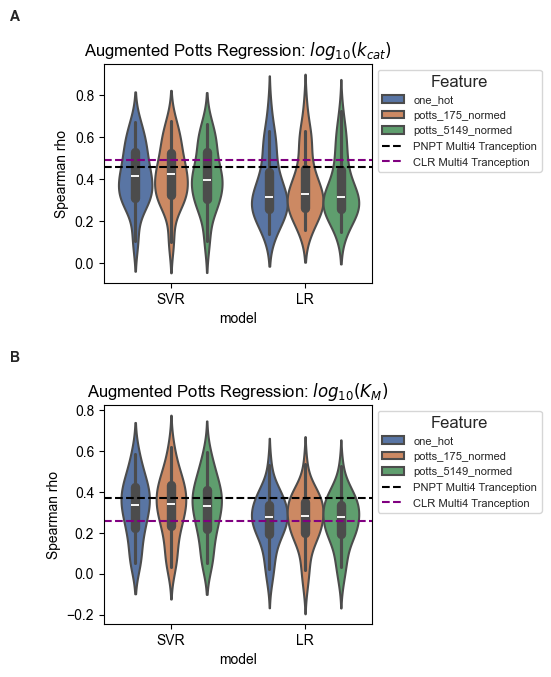

In [16]:
fig, axs = plt.subplots(2,1,figsize=(6.5, 7))
sns.set_theme(style="whitegrid")

########
## kcat
########

sns.violinplot(x="model", y="spearman", hue="feature", data=results_df[results_df["target"]=="log10_kcat"], linewidth=1.5, ax=axs[0])

# add horizontal line for PNPT results
axs[0].axhline(y=pnpt_results_kcat[pnpt_results_kcat["model_name_suffix"]=="kinase_20240822_multi4_PNPT_Tranception"]["Spearman_log10_kcat"].mean(), 
               color="black", linestyle="--", label="PNPT Multi4 Tranception")
axs[0].axhline(y=pnpt_results_kcat[pnpt_results_kcat["model_name_suffix"]=="kinase_20240822_multi4_Tranception"]["Spearman_log10_kcat"].mean(),
                color="purple", linestyle="--", label="CLR Multi4 Tranception")

########
## Km
########

sns.violinplot(x="model", y="spearman", hue="feature", data=results_df[results_df["target"]=="log10_km"], linewidth=1.5, ax=axs[1])

# add horizontal line for PNPT results
axs[1].axhline(y=pnpt_results_km[pnpt_results_km["model_name_suffix"]=="kinase_20240822_multi4_PNPT_Tranception"]["Spearman_log10_km"].mean(),
                color="black", linestyle="--", label="PNPT Multi4 Tranception")
axs[1].axhline(y=pnpt_results_km[pnpt_results_km["model_name_suffix"]=="kinase_20240822_multi4_Tranception"]["Spearman_log10_km"].mean(),
                color="purple", linestyle="--", label="CLR Multi4 Tranception")



axs[0].set_ylabel("Spearman rho")
axs[1].set_ylabel("Spearman rho")

axs[0].legend(loc="upper left", bbox_to_anchor=(1, 1), title="Feature", fontsize=8)
axs[0].set_title("Augmented Potts Regression: $log_{10}(k_{cat})$")

axs[1].set_title("Augmented Potts Regression: $log_{10}(K_M)$")
axs[1].legend(loc="upper left", bbox_to_anchor=(1, 1), title="Feature", fontsize=8)

for ax, label in zip(axs.flat, ["A", "B"]):
    ax.text(-0.35, 1.25, label, transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()